# The Price of Diamonds

This notebook uses the diamond prices dataset to demonstrate usage of a basic stacked model for regression. If you've never used model stacking before, you'll find it's much easier than you expect!

You can follow along here in the notebook, or read my Simple Stacked Model tutorial on Medium here : https://towardsdatascience.com/simple-model-stacking-explained-and-automated-1b54e4357916

# Notebook Setup

## Package Imports

I always start my notebooks with package imports. A few packages don't work here on Kaggle, so we're going to have to work around those. MissForest is an incredibly useful imputation package for imputing missing values in a way that reduces noise over the standard method of imputing mean or median. Unfortunately, this package doesn't play nice here. Kaggle also doesn't support the new as of late 20202 HalvingGridSearchCV, which is Scikit-learn's newest GridSearch method which is ideal for large datasets. I recommend you read up on both of these packages as they are very useful!

In [1]:
# data processing tools
import pandas as pd
import numpy as np
from numpy import mean
from numpy import std
from numpy import argmax
from math import sqrt
import time

# preprocessing
from missingpy import MissForest
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, PolynomialFeatures, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import train_test_split, cross_validate, HalvingGridSearchCV, KFold

# scoring and algorithm selection packages
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.inspection import permutation_importance

import scipy.stats as stats
from scipy.stats import norm

from sklearn.linear_model import LinearRegression, BayesianRidge, ElasticNet, GammaRegressor, Lars, Lasso, SGDRegressor
from sklearn.linear_model import LassoLars, OrthogonalMatchingPursuit, PassiveAggressiveRegressor, PoissonRegressor, RANSACRegressor, Ridge
from sklearn.tree import DecisionTreeRegressor
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.svm import SVR, LinearSVR, NuSVR
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor, ExtraTreesRegressor, AdaBoostRegressor
from sklearn.neighbors import KNeighborsRegressor
import xgboost as xgb

# visualization packages
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# ignore warnings (gets rid of Pandas copy warnings)
import warnings
warnings.filterwarnings('ignore')
pd.options.display.max_columns = None


## Notebook Functions

I like to store my functions at the top of my workflow. This makes it easy to find a function if I need a reminder of what arguments to pass, or how it works.

##### Cleaning Functions

In [2]:
def iqr_outliers(column, iqr_level):
    """return the lower range and upper range for the data based on IQR
    Arguments: 
    column - column to be evaluated
    iqr_level - iqr range to be evaluated
    """
    Q1,Q3 = np.percentile(column , [25,75])
    iqr = Q3 - Q1
    lower_range = Q1 - (iqr_level * iqr)
    upper_range = Q3 + (iqr_level * iqr)
    return lower_range,upper_range  

##### Tuning Functions

In [3]:
def grid_optimizer(model, grid, x, y):
    
    '''Takes in a model and a grid of hyperparameters, and runs a HalvingGridSearch
    arguments: 
    model - the model to be grid searched
    parameter grid - all parameters to grid search
    x, y - train features and target to be tested in search
    returns: best parameters'''
    
    start=time.time()
    
    print("Making Search")
    grid_search = HalvingGridSearchCV(model, grid, verbose=10, scoring='neg_mean_absolute_error', cv=3, min_resources='exhaust')

    print("Running Grid")
    grid_search.fit(x, y)

    grid_search.best_estimator_
    
    # Best f1
    print('Best mae: %.3f' % grid_search.best_score_)

    print("Best parameters set found on train set: \n")
    print(grid_search.best_params_)
    print("\nGrid scores on train set:\n")
    means = grid_search.cv_results_['mean_test_score']
    stds = grid_search.cv_results_['std_test_score']
    for mean, std, params in zip(means, stds, grid_search.cv_results_['params']):
        print("%0.3f (+/-%0.03f) for %r" % (mean, std * 2, params))
    
    print(f'Elapsed Time: {time.time() - start}')
    
    return grid_search.best_params_

##### Scoring Functions

In [4]:
def score_model(model, x, y, model_type, score_list):
    '''Takes in an instantiated model along with x, y and scores it, then appends to list
    Arguments:
    model: tuned/instantiated model
    x, y: train features and targets to be scored with CV
    model_type: label with name of model
    score_list: score list which is then returned back
    Returns: List with scores appended
    '''
    # get accuracy cross val score for cv 5
    scores = cross_validate(model, x, y, cv=5, n_jobs=-1,
        scoring=('r2', 'neg_mean_absolute_error', 'neg_root_mean_squared_error'),
        return_train_score=True)
    r2 = round(scores['test_r2'].mean()*100,2)
    mae = round(scores['test_neg_mean_absolute_error'].mean(), 4)
    mrse = round(scores['test_neg_root_mean_squared_error'].mean(), 4)
    
    print("\n\n",model_type," scores")
    print("CV 5 R2 Train Score: {}".format(r2))
    print("CV 5 MAE Train Score: {}".format(mae))
    print("CV 5 RMSE Train Score: {}".format(mrse))

    # append our scores to our lists
    score_list['model'].append(model_type)
    score_list['r2'].append(r2)
    score_list['mae'].append(mae)
    score_list['rmse'].append(mrse)
    
    return score_list

##### Stacking Functions

In [5]:
def train_oof_predictions(x, y, models, verbose=True):
    '''Function to perform Out-Of-Fold predictions on train data
    returns re-ordered predictors x, re-ordered target y, and model dictionary with filled predictors
    Parameters:
    x: training predictors
    y: training targets
    models: dictionary of models in form of 'model name' : [instantiated model, predictors list]
    verbose: whether to print the sequence of inclusions(True recommended)
    '''
    
    # instantiate a KFold with 10 splits
    kfold = KFold(n_splits=10, shuffle=True, random_state=randomstate)
    
    # prepare lists to hold the re-ordered x and y values
    data_x, data_y  = [], []
    
    # run the following block for each of the 10 kfold splits
    for train_ix, test_ix in kfold.split(x, y):
    
        if verbose: print("\nStarting a new fold\n")
    
        if verbose: print("Creating splits")
        #create this fold's training and test sets
        train_X, test_X = x[train_ix], x[test_ix] 
        train_y, test_y = y[train_ix], y[test_ix]
    
        if verbose: print("Adding x and y to lists\n")
        # add the data that is used in this fold to the re-ordered lists
        data_x.extend(test_X)
        data_y.extend(test_y)
    
        # run each model on this kfold and add the predictors to the model's running predictors list
        for item in models:
            
            label = item # get label for reporting purposes
            model = models[item][0] # get the model to use on the kfold
        
            # fit and make predictions 
            if verbose: print("Running",label,"on this fold")
            model.fit(train_X, train_y) # fit to the train set for the kfold
            predictions = model.predict(test_X) # fit on the out-of-fold set
            models[item][1].extend(predictions) # add predictions to the model's running predictors list
    
    return data_x, data_y, models

In [6]:
def model_selector(X, y, meta_model, models_dict, model_label, verbose=True):
    
    """ 
    Perform a forward model selection based on MAE improvement
    Parameters:
        X - baseline X_train with all features
        y - baseline y_train with all targets
        meta_model - meta_model to be trained
        models_dict - dictionary of models in format of 'model name' : [model object, out-of-fold predictions]
        label - the label for the current meta model
        verbose - whether to print the sequence of inclusions(True recommended)
    Returns: list of selected models, best MAE 
    """

    print("\n\nRunning model selector for ", model_label)
    included_models = []
     
    while True:
        changed=False
        
        # forward step
        
        if verbose: print("\nNEW ROUND - Setting up score charts")
        excluded_models = list(set(models_dict.keys())-set(included_models)) # make a list of the current excluded_models
        if verbose: print("Included models: {}".format(included_models))
        if verbose: print("Exluded models: {}".format(excluded_models))
        new_mae = pd.Series(index=excluded_models) # make a series where the index is the current excluded_models
        
        current_meta_x = np.array(X)
        
        if len(included_models) > 0:
            for included in included_models:
                included = np.array(models_dict[included][1]).reshape((len(models_dict[included][1]), 1))
                current_meta_x = np.hstack((current_meta_x, included))

        # score the current model
        scores = cross_validate(meta_model, current_meta_x, y, cv=5, n_jobs=-1, scoring=('neg_mean_absolute_error'))
        starting_mae = round(scores['test_score'].mean(),4)
        if verbose: print("Starting mae: {}\n".format(starting_mae))
        
       
        for excluded in excluded_models:  # for each item in the excluded_models list:
            
            new_yhat = np.array(models_dict[excluded][1]).reshape(-1, 1) # get the current item's predictions
            meta_x = np.hstack((current_meta_x, new_yhat)) # add the predictions to the meta set
            
            # score the current item
            scores = cross_validate(meta_model, meta_x, y, cv=5, n_jobs=-1, scoring=('neg_mean_absolute_error'))
            mae = round(scores['test_score'].mean(),4)
            if verbose: print("{} score: {}".format(excluded, mae))
            
            new_mae[excluded] = mae # append the mae to the series field
        
        best_mae = new_mae.max() # evaluate best mae of the excluded_models in this round
        if verbose: print("Best mae: {}\n".format(best_mae))
        
        if best_mae > starting_mae:  # if the best mae is better than the initial mae
            best_feature = new_mae.idxmax()  # define this as the new best feature
            included_models.append(str(best_feature)) # append this model name to the included list
            changed=True # flag that we changed it
            if verbose: print('Add  {} with mae {}\n'.format(best_feature, best_mae))
        else: changed = False
        
        if not changed:
            break
            
    print(model_label, "model optimized")
    print('resulting models:', included_models)
    print('MAE:', starting_mae)
    
    return included_models, starting_mae

In [7]:
def create_meta_dataset(data_x, items):
    '''Function that takes in a data set and list of predictions, and forges into one dataset
    parameters:
    data_x - original data set
    items - list of predictions
    returns: stacked data set
    '''
    
    meta_x = data_x
    
    for z in items:
        z = np.array(z).reshape((len(z), 1))
        meta_x = np.hstack((meta_x, z))
        
    return meta_x

In [8]:
def stack_prediction(X_test, final_models): 
    '''takes in a test set and a list of fitted models.
    Fits each model in the list on the test set and stores it in a predictions list
    Then sends the test set and the predictions to the create_meta_dataset to be combined
    Returns: combined meta test set
    Parameters:
    X_test - testing dataset
    final_dict - list of fitted models
    '''
    predictions = []
    
    for item in final_models:
        print(item)
        preds = item.predict(X_test).reshape(-1,1)
        predictions.append(preds)
    
    meta_X = create_meta_dataset(X_test, predictions)
        
    return meta_X

# Obtaining the Data

In [9]:
# I load in my dataframe as always
df = pd.read_csv('diamonds.csv')
df

,Unnamed: 0,carat,cut,color,clarity,depth,table,price,x,y,z
0,1,0.23,Ideal,E,SI2,61.5,55.0,326,3.95,3.98,2.43
1,2,0.21,Premium,E,SI1,59.8,61.0,326,3.89,3.84,2.31
2,3,0.23,Good,E,VS1,56.9,65.0,327,4.05,4.07,2.31
3,4,0.29,Premium,I,VS2,62.4,58.0,334,4.20,4.23,2.63
4,5,0.31,Good,J,SI2,63.3,58.0,335,4.34,4.35,2.75
...,...,...,...,...,...,...,...,...,...,...,...
53935,53936,0.72,Ideal,D,SI1,60.8,57.0,2757,5.75,5.76,3.50
53936,53937,0.72,Good,D,SI1,63.1,55.0,2757,5.69,5.75,3.61
53937,53938,0.70,Very Good,D,SI1,62.8,60.0,2757,5.66,5.68,3.56
53938,53939,0.86,Premium,H,SI2,61.0,58.0,2757,6.15,6.12,3.74


In [10]:
# Drop the first unneeded row, and check the shape of our dataframe.

df.drop('Unnamed: 0', axis=1, inplace=True)

df.shape

(53940, 10)

In [11]:
# What kind of info is stored in the dataframe?
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 53940 entries, 0 to 53939
Data columns (total 10 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   carat    53940 non-null  float64
 1   cut      53940 non-null  object 
 2   color    53940 non-null  object 
 3   clarity  53940 non-null  object 
 4   depth    53940 non-null  float64
 5   table    53940 non-null  float64
 6   price    53940 non-null  int64  
 7   x        53940 non-null  float64
 8   y        53940 non-null  float64
 9   z        53940 non-null  float64
dtypes: float64(6), int64(1), object(3)
memory usage: 4.1+ MB


In [12]:
# Any missing values?
df.isna().sum()

carat      0
cut        0
color      0
clarity    0
depth      0
table      0
price      0
x          0
y          0
z          0
dtype: int64

# S - Scrubbing the Data

We want to drop any duplicate data rows

In [13]:
df.drop_duplicates(keep='last', inplace=True)

Let's check our distributions. We see something interesting! There were no actual missing values, BUT there are several spots where values are 0 in x, y and z. Those are missing values! We also see some outliers in table, x and y. We will address all of these.

In [14]:
df.describe()

,carat,depth,table,price,x,y,z
count,53794.00000,53794.000000,53794.000000,53794.000000,53794.000000,53794.000000,53794.000000
mean,0.79778,61.748080,57.458109,3933.065082,5.731214,5.734653,3.538714
std,0.47339,1.429909,2.233679,3988.114460,1.120695,1.141209,0.705037
min,0.20000,43.000000,43.000000,326.000000,0.000000,0.000000,0.000000
25%,0.40000,61.000000,56.000000,951.000000,4.710000,4.720000,2.910000
50%,0.70000,61.800000,57.000000,2401.000000,5.700000,5.710000,3.530000
75%,1.04000,62.500000,59.000000,5326.750000,6.540000,6.540000,4.030000
max,5.01000,79.000000,95.000000,18823.000000,10.740000,58.900000,31.800000


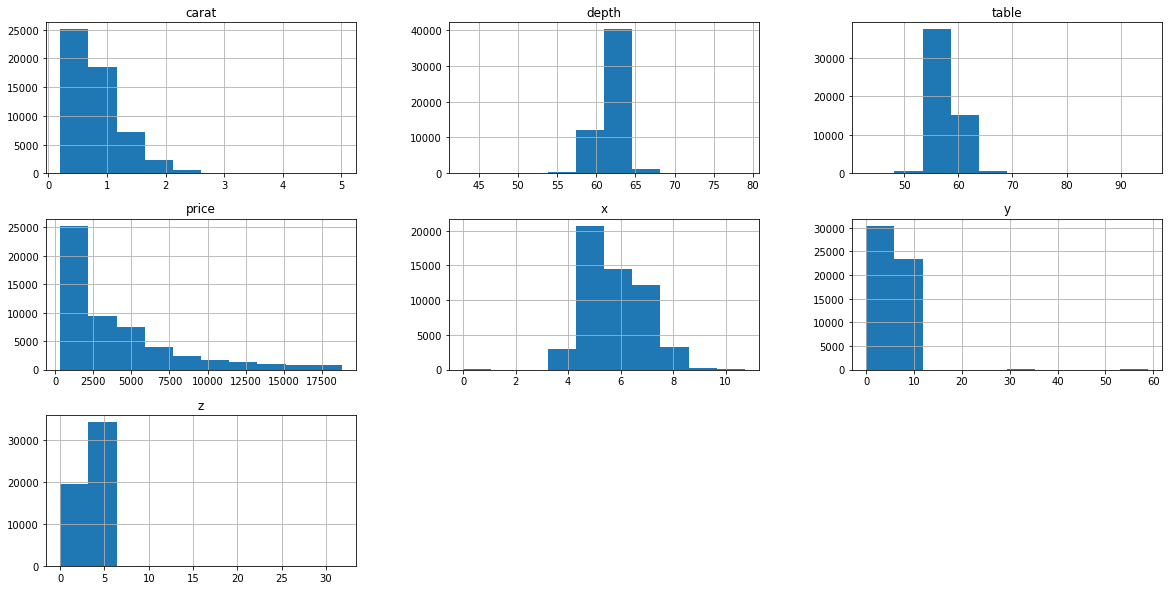

In [15]:
# We look at our histograms
df.hist(figsize=(20,10));

We can see in our histogram that there are extreme right tails on our carat field. Let's take a look at where our percentiles fall, and remove the outliers.

In [16]:
# 99.4 percentile on carat
np.percentile(df.carat, [99.4])

array([2.28])

In [17]:
# determing our IQR range for carat size
caratlower,caratupper = iqr_outliers(df.carat, 1.94)

caratlower, caratupper

(-0.8416, 2.2816)

In [18]:
# dropping the things outside of our lower and upper range
df.drop(df[ (df.carat > caratupper) | (df.carat < caratlower) ].index , inplace=True)

We see in our describe, and in our histograms, that although we didn't find any missing data using isna(), there are actually 0 values in the x, y and z columns. We're going to change these to NaN because we will impute these later with MissForest.

In [19]:
df.loc[df['x']==0, 'x'] = None
df.loc[df['y']==0, 'y'] = None
df.loc[df['z']==0, 'z'] = None

In [20]:
# Now we DO have NaN values - but now that's on purpose!
df.isna().sum()

carat       0
cut         0
color       0
clarity     0
depth       0
table       0
price       0
x           7
y           6
z          18
dtype: int64

Now we're going to clear out those high outliers from z and y by setting those to NaN as well.

In [21]:
# There are clearly some problematically high numbers in our "y" and "z" columns. We're going to get fix these outliers.
df.sort_values('z',ascending=False)

,carat,cut,color,clarity,depth,table,price,x,y,z
48410,0.51,Very Good,E,VS1,61.8,54.7,1970,5.12,5.15,31.80
24067,2.00,Premium,H,SI2,58.9,57.0,12210,8.09,58.90,8.06
26194,2.01,Fair,G,SI2,65.6,56.0,15562,7.89,7.84,6.16
17691,2.27,Fair,G,I1,68.6,56.0,7131,7.99,7.94,5.47
16439,2.22,Fair,H,I1,70.1,55.0,6564,7.77,7.74,5.44
...,...,...,...,...,...,...,...,...,...,...
27112,2.20,Premium,H,SI1,61.2,59.0,17265,8.42,8.37,NaN
27429,2.25,Premium,H,SI2,62.8,59.0,18034,NaN,NaN,NaN
27503,2.02,Premium,H,VS2,62.7,53.0,18207,8.02,7.95,NaN
49557,0.71,Good,F,SI2,64.1,60.0,2130,NaN,NaN,NaN


In [22]:
# Checking the y outliers as well
df.sort_values('y',ascending=False)

,carat,cut,color,clarity,depth,table,price,x,y,z
24067,2.00,Premium,H,SI2,58.9,57.0,12210,8.09,58.90,8.06
49189,0.51,Ideal,E,VS1,61.8,55.0,2075,5.15,31.80,5.12
17097,2.17,Fair,G,I1,55.6,62.0,6817,8.75,8.69,4.80
26559,2.26,Good,I,SI2,56.9,60.0,16241,8.73,8.66,4.95
25076,2.25,Very Good,J,SI2,58.4,63.0,13597,8.60,8.65,5.04
...,...,...,...,...,...,...,...,...,...,...
15951,1.14,Fair,G,VS1,57.5,67.0,6381,NaN,NaN,NaN
24520,1.56,Ideal,G,VS2,62.2,54.0,12800,NaN,NaN,NaN
26243,1.20,Premium,D,VVS1,62.1,59.0,15686,NaN,NaN,NaN
27429,2.25,Premium,H,SI2,62.8,59.0,18034,NaN,NaN,NaN


In [23]:
# Set the outliers to NaN for later imputation
df.loc[[24067, 49189], 'y'] = None
df.loc[48410, 'z'] = None

In [24]:
# Recheck our distribution
df.describe()

,carat,depth,table,price,x,y,z
count,53483.000000,53483.000000,53483.000000,53483.000000,53476.000000,53475.000000,53464.000000
mean,0.787624,61.746622,57.453877,3866.279322,5.714545,5.716679,3.528681
std,0.454818,1.425617,2.232456,3895.942658,1.098173,1.090608,0.678467
min,0.200000,43.000000,43.000000,326.000000,3.730000,3.680000,1.070000
25%,0.400000,61.000000,56.000000,945.000000,4.710000,4.720000,2.910000
50%,0.700000,61.800000,57.000000,2386.000000,5.690000,5.700000,3.520000
75%,1.040000,62.500000,59.000000,5258.500000,6.530000,6.530000,4.030000
max,2.280000,79.000000,95.000000,18818.000000,8.800000,8.690000,8.060000


Our improved histograms after outlier removal and removing bad values. We will fix those bad values during our preprocessing pipeline.

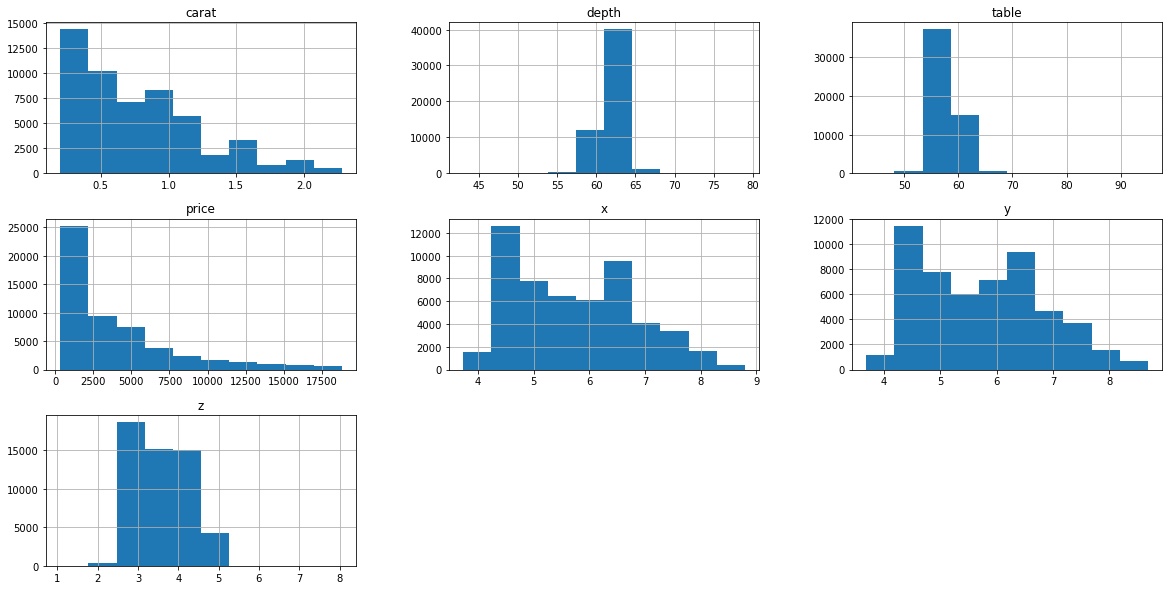

In [25]:
df.hist(figsize=(20,10));

# Exploring the Data

##### Study Target Variable

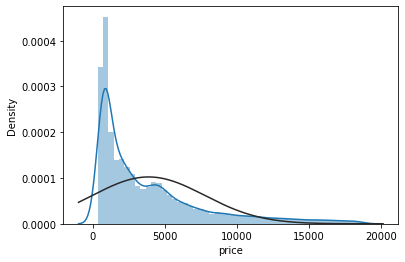

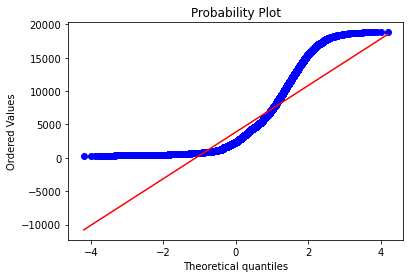

In [26]:
#histogram and normal probability plot
sns.distplot(df['price'], fit=norm);
fig = plt.figure()

res = stats.probplot(df['price'], plot=plt)

# our sales price histogram is positively skewed and has a high peak
# Our QQ-plot shows that we have heavy tails with right skew

In [27]:
#skewness and kurtosis
print("Skewness: %f" % df['price'].skew())
print("Kurtosis: %f" % df['price'].kurt())

# price is highly right skewed
# very positive kurtosis, indicating lots in the tails. We can see those tails in skew.

Skewness: 1.623181
Kurtosis: 2.249963


Our skewness under 2 still falls within an acceptable range. Kurtosis is quite high. Since we have a strong right skew, we can better normalize our distribution with a log transformation.

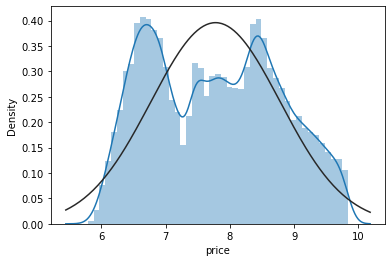

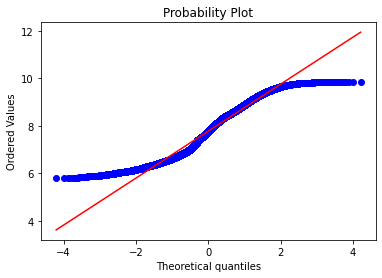

In [28]:
# log transform our target price to improve normality of distribution
df_target_log = np.log(df['price'])

#histogram and normal probability plot
sns.distplot(df_target_log, fit=norm);
fig = plt.figure()
res = stats.probplot(df_target_log, plot=plt)

# Our target price is more normally distributed when log transformed, so we'll be doing that

##### Correlations/Multicollinearity

Next we'll check our features with a Pearson Correlation Matrix, and see if any of our features are highly correlated and therefore redundant.

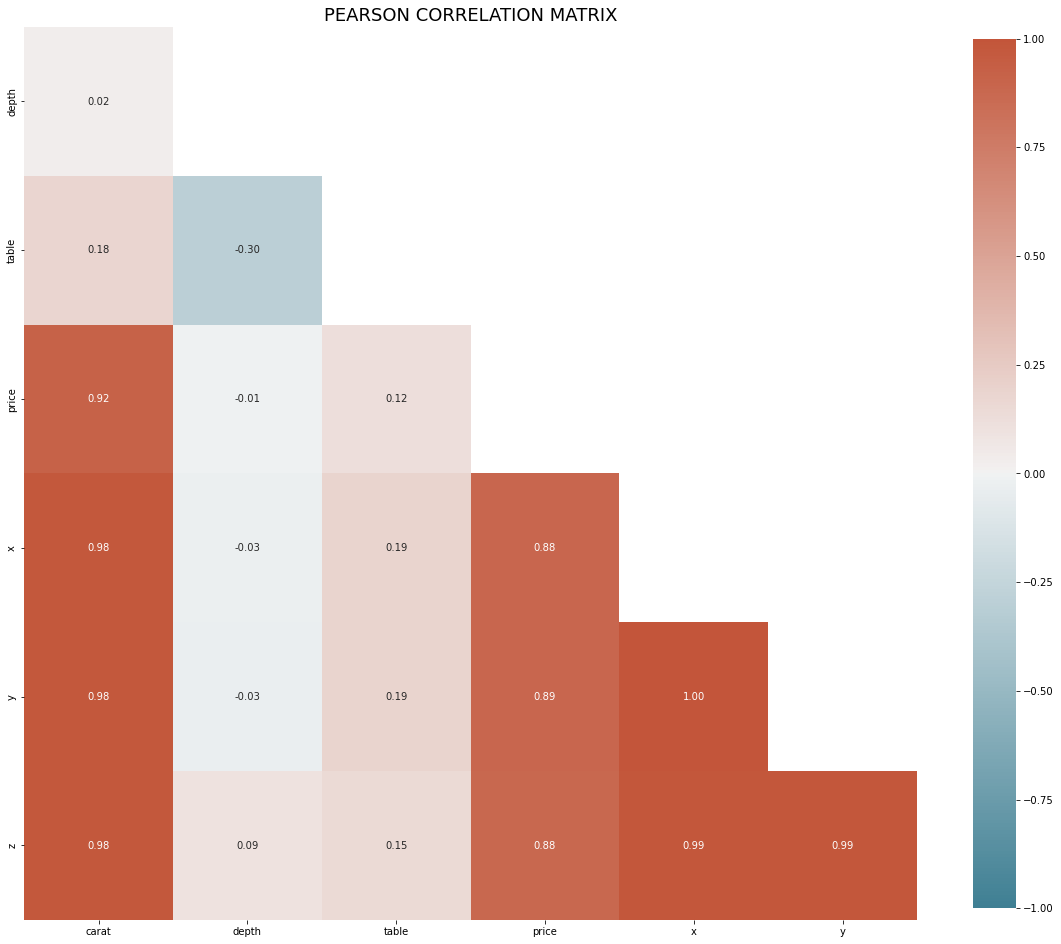

In [29]:
# look for multicollinearity of features
fig, ax = plt.subplots(figsize=(20, 20))

# get the correlations for our train data
df_c = df.corr()

# we want our heatmap to not show the upper triangle, which is redundant data
# get a mask for the upper diagonal
df_c_mask = np.triu(np.ones_like(df_c, dtype=bool))

# adjust mask and df to hide center diagonal
df_c_mask = df_c_mask[1:, :-1]
corr = df_c.iloc[1:,:-1].copy()

# color map
cmap = sns.diverging_palette(220, 20, as_cmap=True)

# plot heatmap
sns.heatmap(corr, mask=df_c_mask, annot=True, fmt=".2f", cmap=cmap,
           vmin=-1, vmax=1, cbar_kws={"shrink": .8}, square=True)

# title
plt.title('PEARSON CORRELATION MATRIX', fontsize=18)

plt.show()

In [30]:
df.corr()

,carat,depth,table,price,x,y,z
carat,1.000000,0.024012,0.182090,0.921508,0.980456,0.979679,0.978644
depth,0.024012,1.000000,-0.297140,-0.013350,-0.028368,-0.031425,0.094386
table,0.182090,-0.297140,1.000000,0.124905,0.194890,0.188592,0.154076
price,0.921508,-0.013350,0.124905,1.000000,0.883571,0.885226,0.878219
x,0.980456,-0.028368,0.194890,0.883571,1.000000,0.998606,0.990631
y,0.979679,-0.031425,0.188592,0.885226,0.998606,1.000000,0.990546
z,0.978644,0.094386,0.154076,0.878219,0.990631,0.990546,1.000000


In [31]:
#Get our list of highly correlated feature pairs with following steps:

# save correlation matrix as a new data frame
# converts all values to absolute value
# stacks the row:column pairs into a multindex
# reset the index to set the multindex to seperate columns
# sort values. 0 is the column automatically generated by the stacking
df_correlations = df.corr().abs().stack().reset_index().sort_values(0, ascending=False)

# zip the variable name columns in a new column named "pairs"
df_correlations['pairs'] = list(zip(df_correlations.level_0, df_correlations.level_1))

# set index to pairs
df_correlations.set_index(['pairs'], inplace = True)

# rename our results column to correlation
df_correlations.rename(columns={0: "correlation"}, inplace=True)

# Drop 1:1 correlations to get rid of self pairs
df_correlations.drop(df_correlations[df_correlations['correlation'] == 1.000000].index, inplace=True)

# view pairs above 70% correlation and below 90% correlation (engineered features will correlate with each other above 95%)
df_correlations[(df_correlations.correlation>.75) & (df_correlations.correlation<.99)]

,level_0,level_1,correlation
pairs,,,
"(x, carat)",x,carat,0.980456
"(carat, x)",carat,x,0.980456
"(carat, y)",carat,y,0.979679
"(y, carat)",y,carat,0.979679
"(z, carat)",z,carat,0.978644
"(carat, z)",carat,z,0.978644
"(price, carat)",price,carat,0.921508
"(carat, price)",carat,price,0.921508
"(y, price)",y,price,0.885226


We're happy to see so many features strongly correlated with price! That bodes very well! 

However, x, y and z all correlate very strongly with each other, as well as with carat. We will need to use feature selection to determine if these are important to keep, or if we should eliminate some/all of them.

##### Visualizing Categorical and Continuous

First we'll visualize our categoricals. If there is any clear trend, we could ordinal encode these into a continuous. Otherwise, they should remain as categorical.

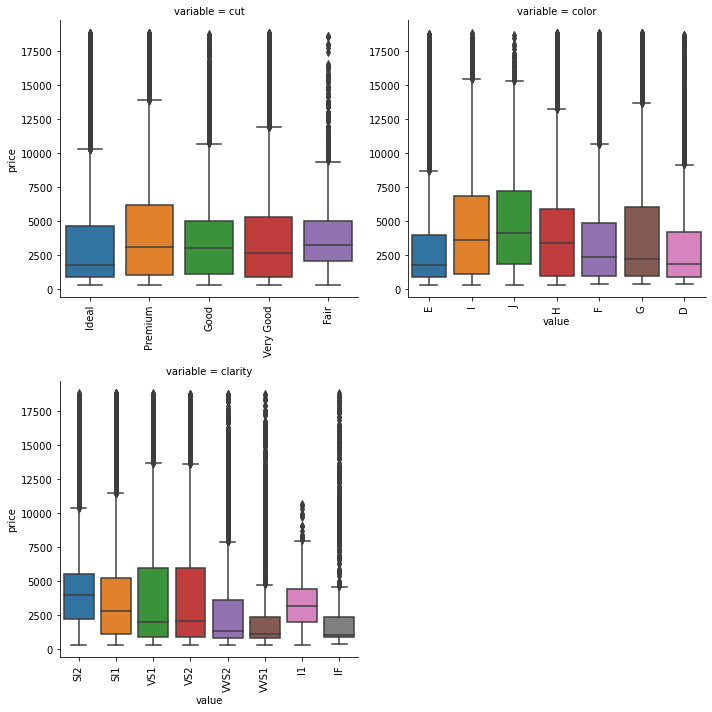

In [32]:
categoricals = ['cut', 'color', 'clarity']

# prepare a new dataframe that has the correct categorical columns
df_categoricals = df[categoricals]

# telling Pandas that these columns are categoricals
for item in categoricals:
    df_categoricals[item] = df_categoricals[item].astype('category')

# adding price to our dataframe so that we can do some visualizations    
df_categoricals['price'] = df['price']

# plot our categoricals as box plots vs price
def boxplot(x, y, **kwargs):
    sns.boxplot(x=x, y=y)
    x=plt.xticks(rotation=90)
    
f = pd.melt(df_categoricals, id_vars=['price'], value_vars=categoricals)
g = sns.FacetGrid(f, col="variable",  col_wrap=2, sharex=False, sharey=False, size=5)
g = g.map(boxplot, "value", "price")

Next we check on the linearity of our continuous variables. Here we can get a sense of if any of these would be better expressed as polynomial relationships.

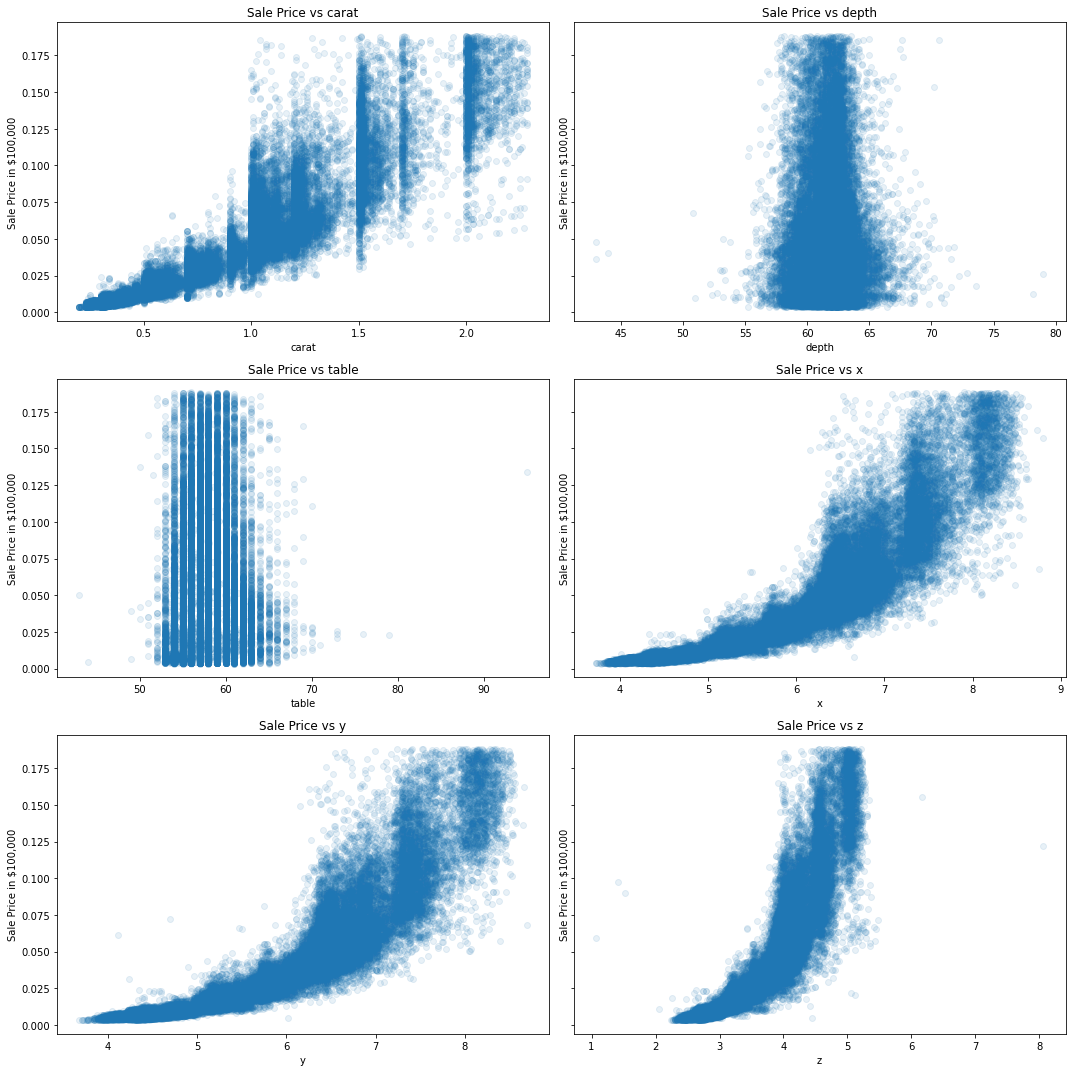

In [33]:
continuous = ['carat', 'depth', 'table', 'x', 'y', 'z']
df_continuous = df[continuous]
df_continuous['price'] = df['price']


# check linearity of continuous predictors

fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(15,15), sharey=True)

for ax, column in zip(axes.flatten(), df_continuous.columns):
    ax.scatter(df_continuous[column], df_continuous['price']/100000, label=column, alpha=.1)
    ax.set_title(f'Sale Price vs {column}')
    ax.set_xlabel(column)
    ax.set_ylabel('Sale Price in $100,000')

fig.tight_layout()

We can see potential polynomial features in these continuous visualizations.

##### Polynomial Relationships

Visualizing the polynomial relationships in our continuous data.

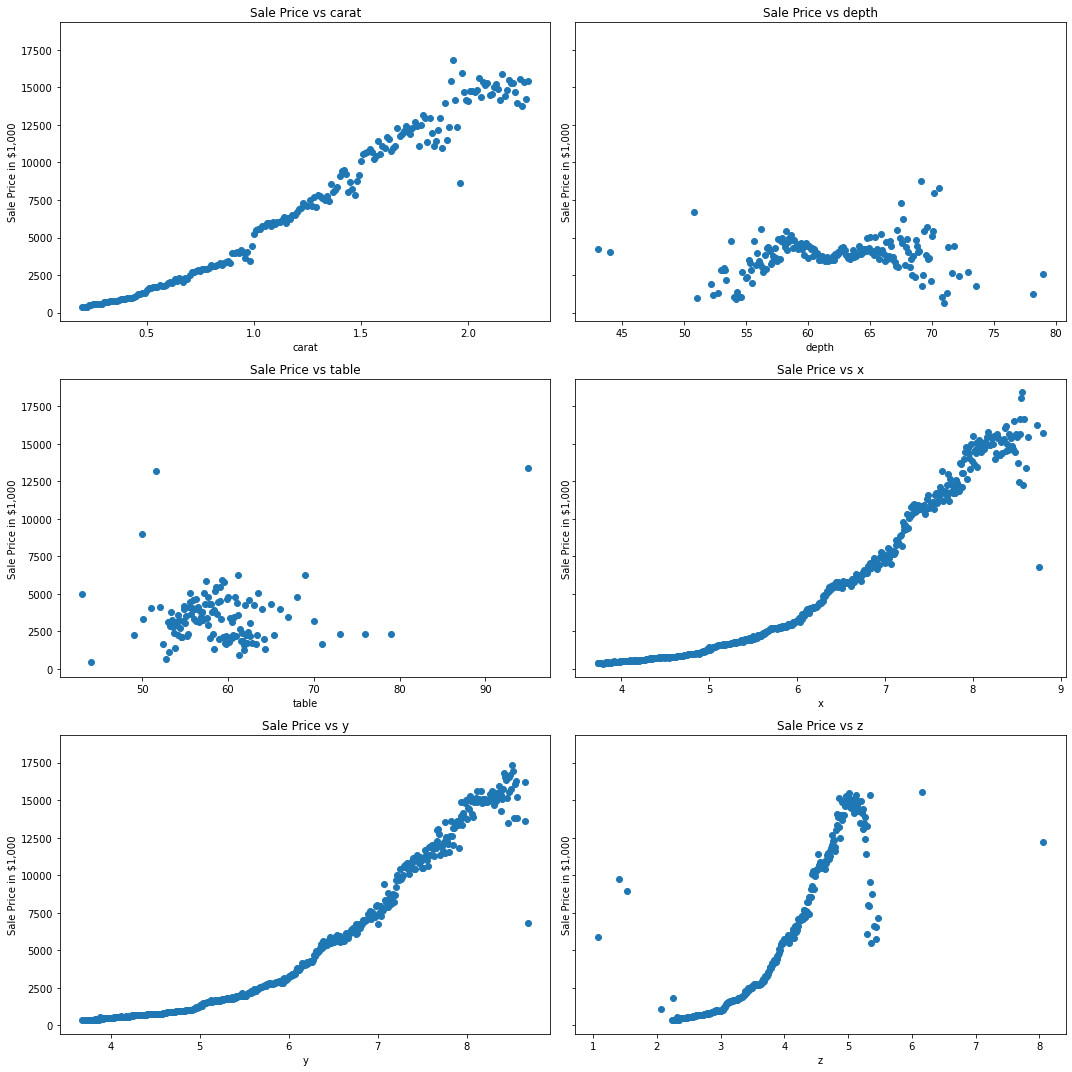

In [34]:
# check linearity of continuous predictors

fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(15,15), sharey=True)

for ax, column in zip(axes.flatten(), df_continuous.columns):   
    carat_price = df.groupby(column)['price'].mean()
    ax.scatter(carat_price.index, carat_price)
    ax.set_title(f'Sale Price vs {column}')
    ax.set_xlabel(column)
    ax.set_ylabel('Sale Price in $1,000')

fig.tight_layout()

Based on what we see in these visuals, we're going to add a polynomial-2 to all of our continuous variables.

# Cleaning Final Data

##### Train/Test Split

It's time to divide our data into the train/test split so that we can standardize our data.

In [35]:
y = np.log(df['price'])
x = df.drop('price', axis=1)

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=.2, random_state=42)

# reset indices to prevent any index mismatches
x_train.reset_index(inplace=True, drop=True)
x_test.reset_index(inplace=True, drop=True)
y_train.reset_index(inplace=True, drop=True)
y_test.reset_index(inplace=True, drop=True)

# exponentiate our y to get an actual price
y_actual = np.exp(y_test)

##### Set up pipeline

Categorical pipeline:
* One Hot Encoder

Continuous pipeline:
* Impute NaN with MissForest()
* Standard Scaler
* Polynomials degree 2

In [36]:
# continuous pipeline
cont_pipeline = Pipeline([
    ('imputer', MissForest()),
    ('scaler', StandardScaler()),
    ('polynomials', PolynomialFeatures(degree=2, include_bias=False))
    ])

# Whole pipeline with continuous then categorical transformers
total_pipeline = ColumnTransformer([
    ('continuous', cont_pipeline, continuous),
    ('categorical', OneHotEncoder(), categoricals)
    ])

In [37]:
# Fit and tranform the pipeline on x_train, then transform x_test
x_train = total_pipeline.fit_transform(x_train)
x_test = total_pipeline.transform(x_test)

Iteration: 0
Iteration: 1
Iteration: 2
Iteration: 3
Iteration: 4
Iteration: 0
Iteration: 1
Iteration: 2
Iteration: 3
Iteration: 4
Iteration: 5
Iteration: 6


In [38]:
# Our outputs of the pipeline are numpy arrays; we'll need the columns for feature selection, so we make these back into dataframes
x_train = pd.DataFrame(x_train)
x_test = pd.DataFrame(x_test)

# Modeling

In [40]:
# prepare dictionary to store results
models = {}
models['model'] = []
models['r2'] = []
models['mae'] = []
models['rmse'] = [] 

# pick our random seed
randomstate = 42

## Spot Check Models

In [ ]:
# Set up spot check models
baseline_models = {
    "LR": LinearRegression(),
    "Decision Tree": DecisionTreeRegressor(random_state = randomstate),
    "Elastic Net": ElasticNet(random_state = randomstate, tol=1e-3),#copy_X=True, normalize=False, 
    "Extra Trees": ExtraTreesRegressor(random_state = randomstate),
    "Gradient Boosted" : GradientBoostingRegressor(random_state = randomstate),
    "KNN" : KNeighborsRegressor(),
    "Lars" : Lars(random_state = randomstate, normalize=False), #copy_X=True, 
    "Lasso" : Lasso(random_state = randomstate, tol=1e-3), #copy_X=True, 
    "LinearSVR" : LinearSVR(random_state = randomstate),
    "MLPRegressor" : MLPRegressor(random_state = randomstate),
    "Bayesian Ridge" : BayesianRidge(),
    "Gamma Regressor" : GammaRegressor(),
    "Lasso Lars" : LassoLars(random_state = randomstate), #, copy_X=True, normalize=False
    "Nu SVR": NuSVR(),
    "Orthogonal Matching Pursuit" : OrthogonalMatchingPursuit(),
    "Passive Aggressive" : PassiveAggressiveRegressor(random_state = randomstate),
    "RANSAC" : RANSACRegressor(random_state = randomstate),
    "Ridge" : Ridge(random_state = randomstate, tol=1e-3, normalize=False),
    "SVR" : SVR(),
    "XGB Regressor" : xgb.XGBRegressor(random_state = randomstate),
    "Ada Boost" : AdaBoostRegressor(random_state=randomstate),
    "SGD Regressor" : SGDRegressor(random_state=randomstate),
    "Random Forest Regressor" : RandomForestRegressor(random_state=randomstate)

}

# run spot check on each model inline
for model in baseline_models:
    this_model = baseline_models[model]
    label = model
    spot_check = score_model(this_model, x_train, y_train, label, models)

### Feature Selection

Next we're going to select features using a method called permutation importance. This is a great model-agnostic method that you can use with any model type, and the way it works is very easy to understand. After fitting the model, it calculates a baseline R^2 score. Then for each feature, it scrambles the inputs of that feature, turnings its contribution into noise. The model is evaluated again with the feature scrambled, and the change in overall R^2 is logged as the importance for that feature. After scrambling all features, each feature has been assigned an importance based on the R^2 reduction. You can then select the features that had an effect on R^2 based on your own threshold (I kept anything >= .001) and throw out the remaining features.

You can learn more about this underrated feature selection method here: https://explained.ai/rf-importance/
The article focuses on Random Forest, but discusses permutation importance as an excellent feature selection method for any model type.

In [ ]:
perm_model = LinearRegression()
perm_model.fit(x_train, y_train)


r = permutation_importance(perm_model, x_train, y_train,
                           n_repeats=15,
                            random_state=0,
                          n_jobs=-1)

importances = {}

for i in r.importances_mean.argsort()[::-1]:
    if r.importances_mean[i] >= 0.001:
        importances[x_train.columns[i]] = r.importances_mean[i]
    else: continue
        
importances

important_features = list(importances.keys())

In [ ]:
X_train_perm = x_train[important_features]
models = score_model(perm_model, X_train_perm, y_train, "LR Perm Importance", models)

In [ ]:
model = ExtraTreesRegressor(random_state = randomstate)
X_train_perm = x_train[important_features]
models = score_model(model, X_train_perm, y_train, "Extra Trees Perm Importance", models)

In [ ]:
model = xgb.XGBRegressor(random_state = randomstate)
X_train_perm = x_train[important_features]
models = score_model(model, X_train_perm, y_train, "XGB Perm Importance", models)

### Spot Check Evaluation

In [ ]:
# make data frame from our models dictionary
target = pd.DataFrame(models).reset_index(drop=True)

# sort data frame by mae and reset index
target.sort_values('mae', ascending=False).head(20)

Permutation importance did not improve our mean average error, so we're going to model with our original feature set.

## Final Model Setup

### Prepare Testing Assets

In [41]:
# initialize empty lists for the storage of out-of-fold predictions

xgbr_yhat, gradient_boost_yhat, extra_trees_yhat, decision_tree_yhat, neighbor_yhat, svr_yhat, nu_svr_yhat = [], [], [], [], [], [], []
orth_yhat, linreg_yhat, ridge_yhat, bay_ridge_yhat, mlp_yhat = [], [], [], [], []

In [42]:
# instantiate tuned models

xgbr = xgb.XGBRegressor(
                n_estimators = 500,
                seed=randomstate,
                missing=0,
                eval_metric='mae',
                verbosity=1,
                max_depth = 10,
                eta = .05,
                min_child_weight = 2,
                colsample_bytree = .8,
                reg_alpha = 1e-05,
                )

gradient_boost = GradientBoostingRegressor(
                n_estimators=500,
                random_state=randomstate,
                max_depth = 8,
                learning_rate=.05,
                loss='ls',
                subsample=.7,
                )

extra_trees = ExtraTreesRegressor(random_state = randomstate, 
                                  n_estimators=100,
                                  criterion='squared_error',
                                  max_depth=25,
                                  max_features='auto'
                                  
                                 )

decision_tree = DecisionTreeRegressor(
                random_state=randomstate,
                criterion = 'squared_error',
                max_depth=15,      
            )


neighbor = KNeighborsRegressor(n_neighbors = 4)
svr = SVR(gamma = 'auto', kernel = 'rbf', C=10, epsilon=.05)
nu_svr = NuSVR(kernel = 'rbf', gamma = 'auto')
orth = OrthogonalMatchingPursuit()
linreg = LinearRegression()
ridge = Ridge(random_state = randomstate, tol=1e-3, normalize=False, solver='auto')
bay_ridge = BayesianRidge(alpha_init=50, normalize=False)
mlp = MLPRegressor(random_state = randomstate, solver='lbfgs', activation='logistic', alpha=1, hidden_layer_sizes=100)

In [43]:
data_x= np.array(pd.read_csv('saved_yhat/data_x.csv'))
data_y= np.array(pd.read_csv('saved_yhat/data_y.csv'))
xgbr_yhat= np.array(pd.read_csv('saved_yhat/xgbr_yhat.csv'))
gradient_boost_yhat= np.array(pd.read_csv('saved_yhat/gradient_boost_yhat.csv'))
decision_tree_yhat= np.array(pd.read_csv('saved_yhat/decision_tree_yhat.csv'))
extra_trees_yhat= np.array(pd.read_csv('saved_yhat/extra_trees_yhat.csv'))
neighbor_yhat= np.array(pd.read_csv('saved_yhat/neighbor_yhat.csv'))
svr_yhat= np.array(pd.read_csv('saved_yhat/svr_yhat.csv'))
nu_svr_yhat= np.array(pd.read_csv('saved_yhat/nu_svr_yhat.csv'))
orth_yhat= np.array(pd.read_csv('saved_yhat/orth_yhat.csv'))
linreg_yhat= np.array(pd.read_csv('saved_yhat/linreg_yhat.csv'))
ridge_yhat= np.array(pd.read_csv('saved_yhat/ridge_yhat.csv'))
bay_ridge_yhat= np.array(pd.read_csv('saved_yhat/bay_ridge_yhat.csv'))
mlp_yhat= np.array(pd.read_csv('saved_yhat/mlp_yhat.csv'))

In [44]:
# create the model dictionary to do out-of-fold predictions and model stack testing

models_dict = {'XGB' : [xgbr, xgbr_yhat],
            'Gradient Boosted' : [gradient_boost, gradient_boost_yhat],
            'Extra Trees' : [extra_trees, extra_trees_yhat],
            'Decision Tree' : [decision_tree, decision_tree_yhat],
            'KNN' : [neighbor, neighbor_yhat],
            'SVR' : [svr, svr_yhat],
            'Nu SVR': [nu_svr, nu_svr_yhat],
            'Orthogonal': [orth, orth_yhat],
            'Linear Regression' : [linreg, linreg_yhat],
            'Ridge' : [ridge, ridge_yhat],
            'Bayesian Ridge': [bay_ridge, bay_ridge_yhat],
            'MLP Perceptron': [mlp, mlp_yhat]
              }

### Get OOF Predictions

Time to run our OOF predictions function. We're sending in our train set, our train targets, and the model dictionary that we just set up. We'll have returned to us a re-ordered train and target set, as well as a model dictionary with full yhat prediction lists.

In [ ]:
# run the out-of-fold predictions
# This takes a long time!!

#data_x, data_y, models_dict = train_oof_predictions(x_train, y_train, models_dict)

#### Save Yhat Predictions

In [ ]:
'''pd.DataFrame(data_x).to_csv('saved_yhat/data_x.csv', index=False)
pd.DataFrame(data_y).to_csv('saved_yhat/data_y.csv', index=False)
pd.DataFrame(xgbr_yhat).to_csv('saved_yhat/xgbr_yhat.csv', index=False)
pd.DataFrame(gradient_boost_yhat).to_csv('saved_yhat/gradient_boost_yhat.csv', index=False)
pd.DataFrame(decision_tree_yhat).to_csv('saved_yhat/decision_tree_yhat.csv', index=False)
pd.DataFrame(extra_trees_yhat).to_csv('saved_yhat/extra_trees_yhat.csv', index=False)
pd.DataFrame(neighbor_yhat).to_csv('saved_yhat/neighbor_yhat.csv', index=False)
pd.DataFrame(svr_yhat).to_csv('saved_yhat/svr_yhat.csv', index=False)
pd.DataFrame(nu_svr_yhat).to_csv('saved_yhat/nu_svr_yhat.csv', index=False)
pd.DataFrame(orth_yhat).to_csv('saved_yhat/orth_yhat.csv', index=False)
pd.DataFrame(linreg_yhat).to_csv('saved_yhat/linreg_yhat.csv', index=False)
pd.DataFrame(ridge_yhat).to_csv('saved_yhat/ridge_yhat.csv', index=False)
pd.DataFrame(bay_ridge_yhat).to_csv('saved_yhat/bay_ridge_yhat.csv', index=False)
pd.DataFrame(mlp_yhat).to_csv('saved_yhat/mlp_yhat.csv', index=False)'''

### Run Stack Selector

In [ ]:
# Set up a scoring dictionary to hold the model stack selector results
scores = {}
scores['Model'] = []
scores['MAE'] = []
scores['Included'] = []

# Run the model stack selector for each model in our models_dict

for model in models_dict:
    
    label = model
    meta_model = models_dict[model][0]

    resulting_models, best_mae = model_selector(data_x, data_y, meta_model, models_dict, label, verbose=True)
    
    scores['Model'].append(model)
    scores['MAE'].append(best_mae)
    scores['Included'].append(resulting_models)

In [ ]:
# Look at the scores of our model combinations

best_model = pd.DataFrame(scores).reset_index(drop=True)
best_model.sort_values('MAE', ascending=False)

### Prepare Final Assets

In [45]:
# make a list with the oof predictions from the stack models that we plan to use in our stack
yhat_predics = [models_dict['XGB'][1],  models_dict['Extra Trees'][1], models_dict['Gradient Boosted'][1],]


# create the meta data set using the oof predictions
meta_X_train = create_meta_dataset(data_x, yhat_predics)

In [46]:
# Fit the models to be used in the stack on the base Train datasets
print("Fitting Models")

print("Fitting XGB")
xgbr.fit(x_train, y_train)

print("Fitting Bay Ridge")
extra_trees.fit(x_train, y_train)

print("Fitting Gradient Boost")
gradient_boost.fit(x_train, y_train)

Fitting Models
Fitting XGB
Fitting Bay Ridge
Fitting Gradient Boost


GradientBoostingRegressor(learning_rate=0.05, loss='ls', max_depth=8,
                          n_estimators=500, random_state=42, subsample=0.7)

In [47]:
# Make a list holding the fitted models to be used in the stack
final_models = [xgbr, extra_trees, gradient_boost]

# Create the test set, including the predictions of the stack models
meta_X_test = stack_prediction(x_test, final_models)

meta_X_test.shape

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.8, enable_categorical=False,
             eta=0.05, eval_metric='mae', gamma=0, gpu_id=-1,
             importance_type=None, interaction_constraints='',
             learning_rate=0.0500000007, max_delta_step=0, max_depth=10,
             min_child_weight=2, missing=0, monotone_constraints='()',
             n_estimators=500, n_jobs=16, num_parallel_tree=1, predictor='auto',
             random_state=42, reg_alpha=1e-05, reg_lambda=1, scale_pos_weight=1,
             seed=42, subsample=1, tree_method='exact', validate_parameters=1, ...)
ExtraTreesRegressor(max_depth=25, random_state=42)
GradientBoostingRegressor(learning_rate=0.05, loss='ls', max_depth=8,
                          n_estimators=500, random_state=42, subsample=0.7)


(10697, 50)

### Final Model Evaluation

In [48]:
# Check our meta model score

linreg = LinearRegression()

linreg.fit(x_train, y_train)
predictions = linreg.predict(x_test)

pred_exp = np.exp(predictions)
actual = np.exp(y_test)

print("MAE: ",int(mean_absolute_error(pred_exp, actual)))
print("RMSE:",int(np.sqrt(mean_squared_error(pred_exp, actual))))
print("R2:", r2_score(pred_exp, actual)*100)

MAE:  355
RMSE: 684
R2: 96.70003482240237


We have an R2 of 96.7%, a mean absolute error of 355,and a rootmeansquared error of 684. Not too bad.

In [49]:
# Check out our best scoring spot check model, too!

trees = extra_trees = ExtraTreesRegressor(random_state = randomstate, 
                                  n_estimators=100,
                                  criterion='squared_error',
                                  max_depth=25,
                                  max_features='auto'
                                  
                                 )

trees.fit(x_train, y_train)
predictions = trees.predict(x_test)

pred_exp = np.exp(predictions)
actual = np.exp(y_test)

print("MAE: ",int(mean_absolute_error(pred_exp, actual)))
print("RMSE:",int(np.sqrt(mean_squared_error(pred_exp, actual))))
print("R2:", r2_score(pred_exp, actual)*100)

MAE:  254
RMSE: 515
R2: 98.17640667031363


Using Extra Trees we have increased our R2 to 98.17% and decreased our mean absolute error to $255, and our root mean squared error to 516. We like that!

In [50]:
# Instantiate the chosen meta model
meta_model =  LinearRegression()

# fit the meta model to the Train meta dataset
# There is no data leakage in the meta dataset since we did all of our predictions out-of-sample
meta_model.fit(meta_X_train, data_y)
predictions = meta_model.predict(meta_X_test)

pred_exp = np.exp(predictions)
actual = np.exp(y_test)

print("MAE: ",int(mean_absolute_error(pred_exp, actual)))
print("RMSE:",int(np.sqrt(mean_squared_error(pred_exp, actual))))
print("R2:", r2_score(pred_exp, actual)*100)

MAE:  243
RMSE: 484
R2: 98.3849566155156


Finally, with our stacked model, we increased our R2 to 98.4% and decresed our mean absolute error to 243 and root mean squared error to 484. This was a 4.7% improvement to our mean average error, and a 6.4% improvement to our root mean squared error. Absolutely worth the time!

# Conclusion

Model stacking is a great way to improve your model performance, and it's easy and fun (if time consuming!). The next time you want to eke out a little extra performance from your project, definitely try out a stack.

# APPENDIX - Parameter Tuning

##### XGBoost

Gradient Boosting performs best with optimal parameter tuning. We're going to use sklearn's GridSearchCV to find the optimal hyperparameters to use with our gradient booster! Here are the parameters we are trying out:

* n_estimators: Number of boosts to perform. Gradient boosting is pretty robust to over-fitting so more is usually better
* max_depth: This determines how many tree nodes the estimator looks at before making a prediction. We don't know what is best here, so we are trying things from 2-4 to see what works the best
* min_child_weight: Min sum of instance weight needed in a child
* gamma: Minimum loss reduction to make another partition on a leaf node. Higher results in more conservative algorithm.
* subsample: Ratio of training sets. .5 means that it will sample half the training data before making trees. Occurs with each boosting iteration.
* colsample_by_tree: ratio of columns when making a tree
* alpha: L1 regularization. Higher will make model more conservative.
* learning_rate: Tuning this setting alters how much the model corrects after it runs a boost. .1 is a common rate and we will test a lower and higher rate as well.

In [ ]:
param_grid = {"max_depth": [5, 10],
              "min_child_weight" : [2, 7],
              'eta': [.05, .1],
              }

xgbr = xgb.XGBRegressor(
                n_estimators=500,
                seed=randomstate,
                missing=0,
                eval_metric='mae',
                verbosity=1)

best_params = grid_optimizer(xgbr, param_grid, x_train, y_train)

Best mae: -0.062
Best parameters set found on train set: 

{'eta': 0.05, 'max_depth': 10, 'min_child_weight': 2}

In [ ]:
param_grid = {"max_depth": [8, 10, 12],
              "min_child_weight" : [2, 4],
              'eta': [.01, .05],
              }

xgbr = xgb.XGBRegressor(
                n_estimators=500,
                seed=randomstate,
                missing=0,
                eval_metric='mae',
                verbosity=1)

best_params = grid_optimizer(xgbr, param_grid, x_train, y_train)

Best mae: -0.062
Best parameters set found on train set: 

{'eta': 0.05, 'max_depth': 10, 'min_child_weight': 2}

In [ ]:
param_grid = {'gamma': [0, .4, .8],
              'subsample':[.2, .6, 1],

              }

xgbr = xgb.XGBRegressor(
                n_estimators=500,
                seed=randomstate,
                missing=0,
                eval_metric='mae',
                verbosity=1,
                max_depth = 10,
                eta = .05,
                min_child_weight = 2)

best_params = grid_optimizer(xgbr, param_grid, x_train, y_train)

Best mae: -0.062
Best parameters set found on train set: 

{'gamma': 0, 'subsample': 1}

In [ ]:
param_grid = {'colsample_bytree':[.2, .4, .6, .8, 1],
              }

xgbr = xgb.XGBRegressor(
                n_estimators=500,
                seed=randomstate,
                missing=0,
                eval_metric='mae',
                verbosity=1,
                max_depth = 10,
                eta = .05,
                min_child_weight = 2,
                )

best_params = grid_optimizer(xgbr, param_grid, x_train, y_train)

Best mae: -0.062
Best parameters set found on train set: 

{'colsample_bytree': 0.8}

In [ ]:
param_grid = {'reg_alpha':[1e-5, 1, 100],
              'reg_lambda':[1e-5, 1, 100],
              }

xgbr = xgb.XGBRegressor(
                n_estimators=500,
                seed=randomstate,
                missing=0,
                eval_metric='mae',
                verbosity=1,
                max_depth = 10,
                eta = .05,
                min_child_weight = 2,
                colsample_bytree = .8,
                )

best_params = grid_optimizer(xgbr, param_grid, x_train, y_train)

Best mae: -0.062
Best parameters set found on train set: 

{'reg_alpha': 1e-05, 'reg_lambda': 1}

In [ ]:
param_grid = {'n_estimators' : [500, 750, 1000],
              }

xgbr = xgb.XGBRegressor(
                seed=randomstate,
                missing=0,
                eval_metric='mae',
                verbosity=1,
                max_depth = 10,
                eta = .05,
                min_child_weight = 2,
                colsample_bytree = .8,
                reg_alpha = 1e-05,
                )

best_params = grid_optimizer(xgbr, param_grid, x_train, y_train)

In [ ]:
xgbr = xgb.XGBRegressor(
                n_estimators = 500,
                seed=randomstate,
                missing=0,
                eval_metric='mae',
                verbosity=1,
                max_depth = 10,
                eta = .05,
                min_child_weight = 2,
                colsample_bytree = .8,
                reg_alpha = 1e-05,
                )

##### Extra Trees

In [ ]:
param_grid = {"max_depth": [15, 25],
              'max_features':['auto','sqrt']
              }

extra_trees = ExtraTreesRegressor(random_state = randomstate, 
                                  n_estimators=100,
                                  criterion='squared_error',
                                  
                                 )

best_params = grid_optimizer(extra_trees, param_grid, x_train, y_train)    

Best mae: -0.066
Best parameters set found on train set: 

{'max_depth': 25, 'max_features': 'auto'}

In [ ]:
param_grid = {"n_estimators": [250, 500, 1000],
              }

extra_trees = ExtraTreesRegressor(random_state = randomstate, 
                                  n_estimators=100,
                                  criterion='squared_error',
                                  max_depth=25,
                                  max_features='auto'
                                  
                                 )

best_params = grid_optimizer(extra_trees, param_grid, x_train, y_train)   

Best mae: -0.065
Best parameters set found on train set: 

{'n_estimators': 1000}

In [ ]:
param_grid = {"n_estimators": [25, 50, 100],
              }

extra_trees = ExtraTreesRegressor(random_state = randomstate, 
                                  n_estimators=100,
                                  criterion='squared_error',
                                  max_depth=25,
                                  max_features='auto'
                                  
                                 )

best_params = grid_optimizer(extra_trees, param_grid, x_train, y_train) 

Best mae: -0.066
Best parameters set found on train set: 

{'n_estimators': 100}

In [ ]:
extra_trees = ExtraTreesRegressor(random_state = randomstate, 
                                  n_estimators=100,
                                  criterion='squared_error',
                                  max_depth=25,
                                  max_features='auto'
                                  
                                 )

##### Gradient Boosted Trees

In [ ]:
param_grid = {"max_depth": [5, 10, 15],
              'learning_rate': [.1, .3],
              }

gradient_boost = GradientBoostingRegressor(
                n_estimators=500,
                random_state=randomstate,
                )

best_params = grid_optimizer(gradient_boost, param_grid, x_train, y_train)

Best mae: -0.064
Best parameters set found on train set: 

{'learning_rate': 0.1, 'max_depth': 10}

In [ ]:
param_grid = {"max_depth": [8, 10, 12],
              'learning_rate': [.05, .1],
              }

gradient_boost = GradientBoostingRegressor(
                n_estimators=500,
                random_state=randomstate,
                )

best_params = grid_optimizer(gradient_boost, param_grid, x_train, y_train)

Best mae: -0.063
Best parameters set found on train set: 

{'learning_rate': 0.05, 'max_depth': 8}

In [ ]:
param_grid = {"min_impurity_decrease" : [0, .5],
              'max_features': ['auto', 'sqrt', 'log2'],
              }

gradient_boost = GradientBoostingRegressor(
                n_estimators=500,
                random_state=randomstate,
                max_depth = 8,
                learning_rate=.05,
                )

best_params = grid_optimizer(gradient_boost, param_grid, x_train, y_train)

Best mae: -0.063
Best parameters set found on train set: 

{'max_features': 'auto', 'min_impurity_decrease': 0}

In [ ]:
param_grid = {'subsample' : [.3, .7, 1],
              'loss': ['lad', 'ls']
              }

gradient_boost = GradientBoostingRegressor(
                n_estimators=500,
                random_state=randomstate,
                max_depth = 8,
                learning_rate=.05,
                )

best_params = grid_optimizer(gradient_boost, param_grid, x_train, y_train)

Best mae: -0.063
Best parameters set found on train set: 

{'loss': 'ls', 'subsample': 0.7}

In [ ]:
param_grid = {'n_estimators' : [500,1000,5000]
              }

gradient_boost = GradientBoostingRegressor(
                n_estimators=500,
                random_state=randomstate,
                max_depth = 8,
                learning_rate=.05,
                loss='ls',
                subsample=.7,
                )

best_params = grid_optimizer(gradient_boost, param_grid, x_train, y_train)

Best mae: -0.063
Best parameters set found on train set: 

{'n_estimators': 500}

In [ ]:
gradient_boost = GradientBoostingRegressor(
                n_estimators=500,
                random_state=randomstate,
                max_depth = 8,
                learning_rate=.05,
                loss='ls',
                subsample=.7,
                )


##### Random Forest

In [ ]:
param_grid = {"max_depth": [5, 10, 15],
              "criterion" : ['squared_error', 'absolute_error']
              }

random_forest = RandomForestRegressor(
                n_estimators=500,
                random_state=randomstate,
                n_jobs=-1)

best_params = grid_optimizer(random_forest, param_grid, x_train, y_train)

Best mae: -0.073
Best parameters set found on train set: 

{'criterion': 'absolute_error', 'max_depth': 15}

In [ ]:
param_grid = {'bootstrap': [True, False],
              'min_samples_leaf' : [1, 10]
              }

random_forest = RandomForestRegressor(
                n_estimators=500,
                random_state=randomstate,
                criterion='absolute_error',
                max_depth=15,
                max_features='auto',)

best_params = grid_optimizer(random_forest, param_grid, x_train, y_train)

In [ ]:
param_grid = {'n_estimators' : [500,1000]
              }

##### KNN

In [ ]:
mae_val = [] #to store mae values for different k

# checks mean absolute error scores on k from 1 to 25
for K in range(0, 20):
    K = K+1 
    # set up the KNN regressor
    model = KNeighborsRegressor(n_neighbors = K)
    # get accuracy cross val score for cv 5
    scores = cross_validate(model, x_train, y_train, cv=5,
        scoring=('neg_mean_absolute_error'),
        return_train_score=True)
    mae = round(scores['test_score'].mean(), 4) 
    mae_val.append(mae) #store mae values
    print('MAE value for k= ' , K , 'is:', mae)
    
# gets optimal k-value based on score minimum
index_max = np.argmax(mae_val) + 1
print(index_max)

##### SVR

In [ ]:
# Parameter Tuning

param_grid = {'kernel' : ['linear', 'rbf', 'poly'],
              'gamma' : ['scale', 'auto']            
              }

svr = SVR()

best_params = grid_optimizer(svr, param_grid, x_train, y_train)

Best mae: -0.081
Best parameters set found on train set: 

{'gamma': 'auto', 'kernel': 'rbf'}

In [ ]:
# Parameter Tuning

param_grid = {'C' : [1,10],
              'epsilon' : [.01,.05]            
              }

svr = SVR(gamma = 'auto', kernel = 'rbf')

best_params = grid_optimizer(svr, param_grid, x_train, y_train)


In [ ]:
svr = SVR(gamma = 'auto', kernel = 'rbf', c=10, epsilon=.05)

##### Nu SVR

In [ ]:
param_grid = {'kernel' : ['linear', 'rbf', 'poly', 'sigmoid'],
              'gamma' : ['scale', 'auto']            
              }

nu_svr = NuSVR()

best_params = grid_optimizer(nu_svr, param_grid, x_train, y_train)

Best mae: -0.077
Best parameters set found on train set: 

{'gamma': 'auto', 'kernel': 'rbf'}

##### Ridge

In [ ]:
# Parameter Tuning

param_grid = {'solver' : ['auto', 'saga', 'cholesky', 'lsqr'],
              }

ridge = Ridge(random_state = randomstate, tol=1e-3, normalize=False)

best_params = grid_optimizer(ridge, param_grid, x_train, y_train)

Best mae: -0.089
Best parameters set found on train set: 

{'solver': 'auto'}

##### Bayesian Ridge

In [ ]:
param_grid = {'alpha_init' : [1, 5, 50],
              'normalize' : [True, False]            
              }

bay_ridge = BayesianRidge()

best_params = grid_optimizer(bay_ridge, param_grid, x_train, y_train)

Best mae: -0.088
Best parameters set found on train set: 

{'alpha_init': 50, 'normalize': False}

##### MLP Regressor

In [ ]:
param_grid = {'solver' : ['lbfgs', 'sgd', 'adam']
              }

mlp = MLPRegressor(random_state = randomstate)

best_params = grid_optimizer(mlp, param_grid, x_train, y_train)

Best mae: -0.086
Best parameters set found on train set: 

{'solver': 'lbfgs'}

##### Decision Tree

In [ ]:
param_grid = {"max_depth": [5, 10, 15],
              "criterion" : ['squared_error', 'absolute_error', 'poisson']
              }

decision_tree = DecisionTreeRegressor(
                #n_estimators=500,
                random_state=randomstate,
                #n_jobs=-1
            )

best_params = grid_optimizer(decision_tree, param_grid, x_train, y_train)

Best mae: -0.087
Best parameters set found on train set: 

{'criterion': 'squared_error', 'max_depth': 15}

In [ ]:
param_grid = {"max_depth": [15, 20],
              "max_features" : ['auto', 'sqrt', 'log2']
              }

decision_tree = DecisionTreeRegressor(
                #n_estimators=500,
                random_state=randomstate,
                #n_jobs=-1,
                criterion = 'squared_error',
                
            )

best_params = grid_optimizer(decision_tree, param_grid, x_train, y_train)

Best mae: -0.088
Best parameters set found on train set: 

{'max_depth': 15, 'max_features': 'auto'}

In [ ]:
decision_tree = DecisionTreeRegressor(
                random_state=randomstate,
                criterion = 'squared_error',
                max_depth=15,      
            )